In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Set up StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

# Load data
excel = pd.read_excel('../Dataset_Process/Dataset/original_data.xlsx', header=2)
data_orginal = pd.DataFrame(excel)

# Filter and preprocess
data = data_orginal[['cC', 'cO', 'cN', 'cF', 'cP', 'cS', 'OCr', 'FCr', 'FOr', 'PCr', 'NCr',
                     'SCr', 'NFr', 'POr', 'NOr', 'SOr', 'PFr', 'SFr', 'SPr', 'NSr', 'FNS/Or',
                     'FP/Or', 'FNS/FPr', 'dendrtic', 'sphere',
                     'Li longitudinal growth size', 'Li longitudinal growth maximum size',
                     'The difference between the maximum longitudinal growth size and average size',
                     'General thickness of deposition', 'Maximum deposition thickness',
                     'Li horizontal growth size', 'Li horizontal growth maximum size',
                     'The difference between the maximum horizontal growth size and average size',
                     'Average deposition density', 'λ value']]

df = data[data['dendrtic'].notnull()]
df = df[(df['dendrtic'] != 0) & (df['sphere'] == 0) | (df['dendrtic'] == 0) & (df['sphere'] != 0)]
df = df[df['Li longitudinal growth size'].notnull()]
df = df.fillna(0)
display(df)

# Features and labels
X = df[['Li longitudinal growth size', 'Li longitudinal growth maximum size',
        'The difference between the maximum longitudinal growth size and average size',
        'General thickness of deposition', 'Maximum deposition thickness',
        'The difference between the maximum horizontal growth size and average size',
        'Li horizontal growth size', 'Li horizontal growth maximum size',
        'Average deposition density', 'λ value']]
y = df['sphere']

# Loop for feature selection
for i in range(5):
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
    
    # Initialize Random Forest Classifier as the base model
    clf = RandomForestClassifier()
    
    # Perform feature selection using RFECV
    selector = RFECV(estimator=clf, step=1, cv=cv, min_features_to_select=2)
    selector = selector.fit(X_train, y_train)
    
    # Output feature selection results
    selected_features = X.columns[selector.support_]
    print(f"Run {i+1}:")
    print("Selected features:", selected_features.tolist())
    print("Feature rankings (lower is better):", selector.ranking_)
    print("RFECV best score (test set accuracy):", selector.score(X_test, y_test))
    
    # Output feature importance
    feature_importance = selector.estimator_.feature_importances_
    print("Feature importances:")
    for feature, importance in zip(selected_features, feature_importance):
        print(f"Feature '{feature}' importance score: {importance}")
    print("-" * 50)


KeyError: "['Li horizontal growth size', 'Li horizontal growth maximum size'] not in index"

Mean CV Score (Negative MAE): -6.5111
CV Score Standard Deviation: 1.8393
Feature Importances:
cC: 0.0736
cO: 0.1157
cS: 0.0086
OCr: 0.0838
FCr: 0.0336
FOr: 0.0659
PCr: 0.0574
NCr: 0.0110
SCr: 0.0071
NFr: 0.0136
POr: 0.0957
NOr: 0.2371
SOr: 0.0863
PFr: 0.0202
SFr: 0.0076
SPr: 0.0000
NSr: 0.0830


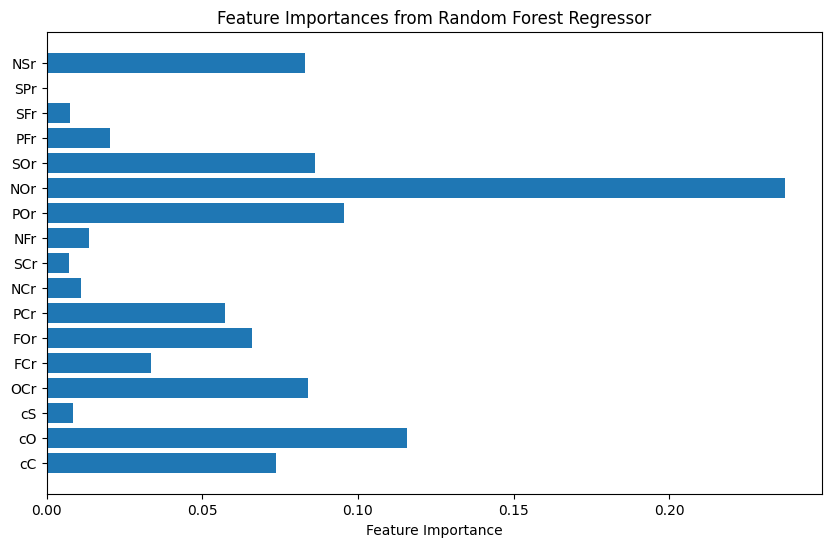

In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# 读取数据
data = pd.read_excel('../Dataset_Process/Dataset/lambda_data.xlsx', sheet_name='all', header=0)
data = data.fillna(data.mean())  # 使用均值填充缺失值
data = data.drop(columns = ['cF','cN','cP','FNS/FPr','FNS/Or','FP/Or'])
X = data[data.columns[:-2]]  # 特征矩阵
y = data['lambda']  # 目标变量

# 初始化随机森林回归器
model = RandomForestRegressor()

# 使用 KFold 进行 5 折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 使用 cross_val_score 计算每个折叠的 MAE (负值)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')

# 计算交叉验证结果的均值和标准差
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# 输出交叉验证的结果
print(f"Mean CV Score (Negative MAE): {mean_cv_score:.4f}")
print(f"CV Score Standard Deviation: {std_cv_score:.4f}")

# 在整个数据集上训练模型，以获取特征重要性
model.fit(X, y)

# 获取特征重要性
feature_importances = model.feature_importances_

# 打印特征重要性
print("Feature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest Regressor')
plt.show()


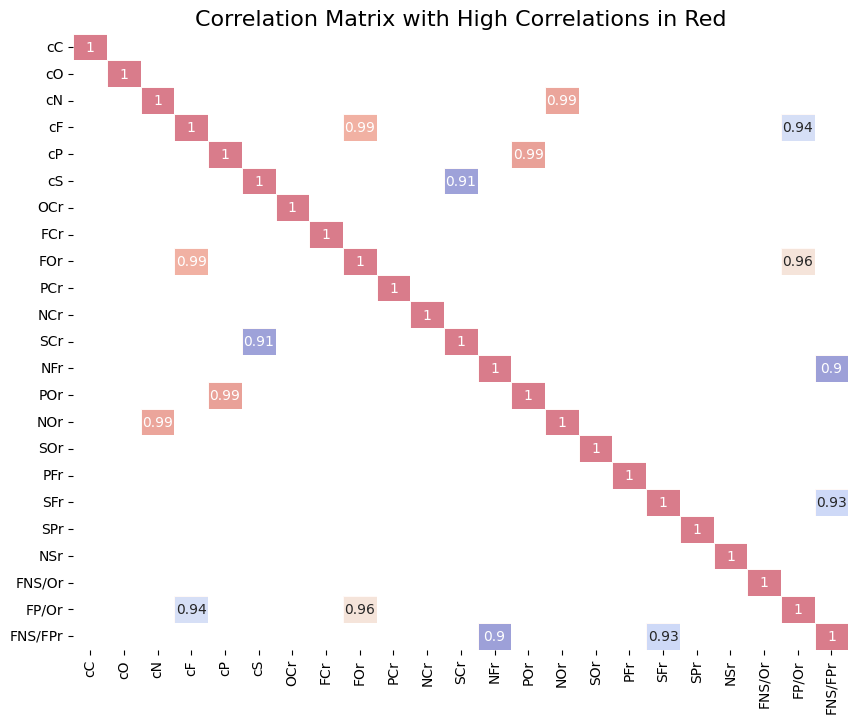

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 计算特征间的相关性矩阵
correlation_matrix = X.corr()

# 创建一个与相关性矩阵相同大小的布尔矩阵，用于标记相关性大于0.9的区域
mask = correlation_matrix > 0.9

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", mask=~mask, cbar=False, linewidths=0.5)

# 可选：在高相关性区域添加红色区域背景
sns.heatmap(mask, annot=False, cmap="Reds", cbar=False, mask=~mask, alpha=0.5)

# 设置标题
plt.title('Correlation Matrix with High Correlations in Red', fontsize=16)

# 显示图形
plt.show()


In [8]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# 读取数据
data = pd.read_excel('../Dataset_Process/Dataset/lambda_data.xlsx', sheet_name='all', header=0)
data = data.fillna(data.mean())  # 使用均值填充缺失值
# data = data.drop(columns = ['cF','cN','cP','FNS/FPr','FNS/Or','FP/Or'])
X = data[data.columns[:-2]]  # 特征矩阵
y = data['lambda']  # 目标变量
pca = PCA(n_components=5)  # 降维到 5 个特征
X_pca = pca.fit_transform(X)

print("PCA 解释方差比例:", pca.explained_variance_ratio_)


PCA 解释方差比例: [0.83236028 0.1170833  0.02445406 0.0107843  0.00588652]


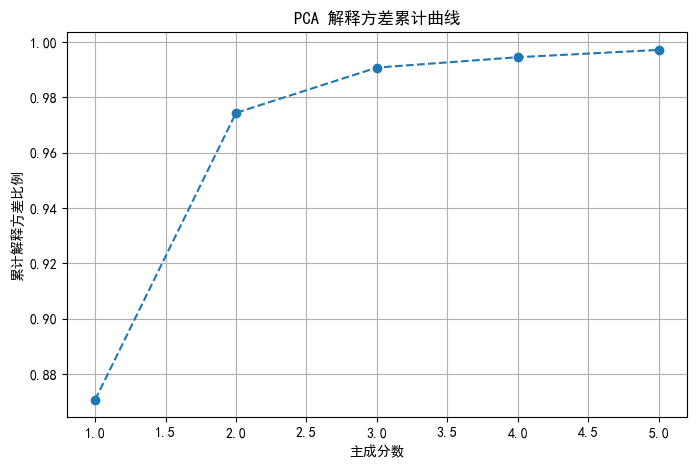

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 计算累计方差贡献率
explained_variance = np.cumsum([0.8705984, 0.10377763, 0.01638391, 0.00374602, 0.00263953])
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号无法显示的问题
# 画折线图
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('主成分数')
plt.ylabel('累计解释方差比例')
plt.title('PCA 解释方差累计曲线')
plt.grid(True)
plt.show()


In [10]:
feature_importance = pd.DataFrame(pca.components_.T, index=X.columns)
print(feature_importance)


                0         1         2         3         4
cC      -0.142292  0.159815 -0.327775  0.102014 -0.613540
cO       0.354687 -0.784729 -0.263953 -0.171497  0.131726
cN       0.001600  0.013117  0.302418 -0.107869  0.152004
cF      -0.157821  0.418507 -0.460299 -0.514341  0.410291
cP      -0.044240  0.099238  0.101836  0.636182  0.257579
cS      -0.003581  0.061849  0.570857 -0.171418  0.220070
OCr      0.908758  0.409300 -0.036246  0.040336 -0.045001
FCr     -0.008088  0.023366 -0.023821 -0.106509  0.274350
FOr     -0.002478  0.007343 -0.007056 -0.006918  0.002581
PCr     -0.004415  0.012025  0.026571  0.095696  0.074838
NCr      0.006409  0.005752  0.078699 -0.044068  0.009280
SCr      0.006825  0.022252  0.144716 -0.054071  0.025464
NFr      0.012425 -0.002151  0.110922 -0.117760 -0.136721
POr     -0.000655  0.001677  0.001411  0.008713  0.003530
NOr     -0.000023  0.000253  0.003903 -0.000943  0.002278
SOr      0.000044  0.000237  0.001820 -0.000514  0.000445
PFr     -0.004

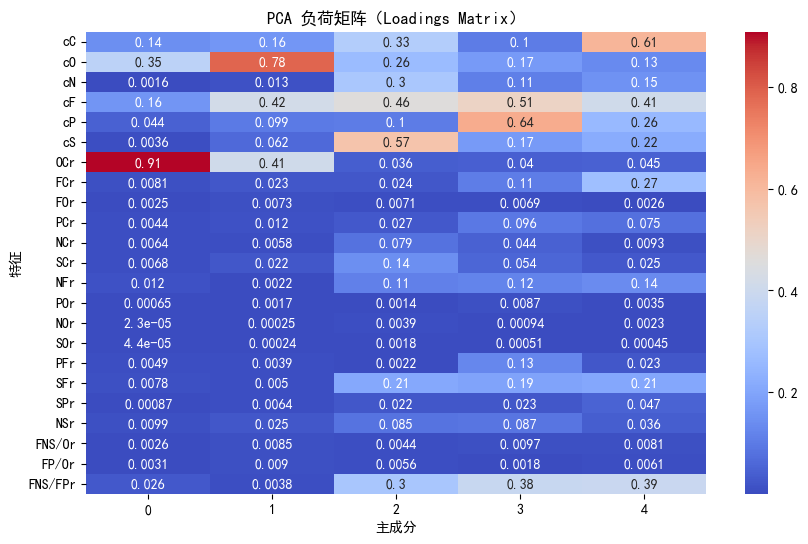

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(abs(feature_importance), annot=True, cmap="coolwarm")
plt.xlabel("主成分")
plt.ylabel("特征")
plt.title("PCA 负荷矩阵（Loadings Matrix）")
plt.show()


In [21]:
import pandas as pd

# 选择需要分析的列
selected_features = ['cN', 'NOr', 'cC', 'cO', 'OCr', 'FOr', 'cF', 'lambda']
data = pd.read_excel('../Dataset_Process/Dataset/lambda_data.xlsx', sheet_name='all', header=0)
data = data.fillna(0)  # 使用均值填充缺失值# 计算相关性

# display(data)
correlation_matrix = data[selected_features].corr()

# 输出相关性
print(correlation_matrix['lambda'].sort_values(ascending=False))  # 按照相关性排序

kendall_corr = df[selected_features].corr(method='kendall')
print(kendall_corr['lambda'].sort_values(ascending=False))


lambda    1.000000
cO        0.332427
OCr       0.300509
cC       -0.177267
FOr      -0.197368
cF       -0.204188
NOr      -0.458861
cN       -0.476377
Name: lambda, dtype: float64
lambda    1.000000
cO        0.202515
OCr       0.057722
cC       -0.027784
cF       -0.093557
FOr      -0.115105
cN       -0.508176
NOr      -0.511548
Name: lambda, dtype: float64


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb

# 选择回归特征和目标变量
selected_features = ['cN', 'NOr', 'cC', 'cO', 'OCr', 'FOr', 'cF']  # 特征
target_variable = 'lambda'  # 目标变量

# 读取数据
data = pd.read_excel('../Dataset_Process/Dataset/lambda_data.xlsx', sheet_name='all', header=0)

# 处理缺失值（推荐使用均值填充）
data = data.fillna(data.mean())

# 定义 X（特征）和 y（目标变量）
X = data[selected_features]
y = data[target_variable]

# 划分训练集和测试集（80% 训练, 20% 测试）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **1️⃣ 训练线性回归**
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# **2️⃣ 训练 XGBoost 回归**
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# **计算 R²（决定系数）**
r2_linear = r2_score(y_test, y_pred_linear)
r2_xgb = r2_score(y_test, y_pred_xgb)

# **计算误差**
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

# **打印结果**
print(f"📌 线性回归 R²: {r2_linear:.4f}, MAE: {mae_linear:.4f}, MSE: {mse_linear:.4f}")
print(f"📌 XGBoost 回归 R²: {r2_xgb:.4f}, MAE: {mae_xgb:.4f}, MSE: {mse_xgb:.4f}")


📌 线性回归 R²: 0.2396, MAE: 10.2085, MSE: 147.1081
📌 XGBoost 回归 R²: 0.1270, MAE: 11.2863, MSE: 168.8733


In [ ]:
# 去掉F、N、P三个与FNS/FPr
# F、N和O组合时均极度相关

In [28]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -------- ------------------------------- 2.1/9.8 MB 8.4 MB/s eta 0:00:01
   ------------------ --------------------- 4.5/9.8 MB 10.3 MB/s eta 0:00:01
   ---------------------------- ----------- 7.1/9.8 MB 10.9 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.8 MB 11.0 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 11.0 MB/s eta 0:00:00


In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 逐步回归方法
def stepwise_regression(X, y, threshold_in=0.01, threshold_out=0.05):
    """逐步回归方法，使用p-value进行特征选择"""
    
    # 初始模型包含常数项
    initial_features = X.columns.tolist()
    selected_features = []
    
    while True:
        # 拟合当前模型
        X_selected = X[selected_features] if selected_features else sm.add_constant(X[selected_features])
        model = sm.OLS(y, X_selected).fit()
        
        # 获取p-value和R-squared
        p_values = model.pvalues.iloc[1:]  # 不包括常数项
        max_p_value = p_values.max()
        
        # 如果最大p-value大于阈值，则移除对应的特征
        if max_p_value >= threshold_out:
            feature_to_remove = p_values.idxmax()
            selected_features.remove(feature_to_remove)
        else:
            break
    
    return selected_features

data = pd.read_excel('../Dataset_Process/Dataset/lambda_data.xlsx', sheet_name='all', header=0)
data = data.fillna(0)  # 使用均值填充缺失值
# data = data.drop(columns = ['cF','cN','cP','FNS/FPr','FNS/Or','FP/Or'])
X = data[data.columns[:-2]]  # 特征矩阵
y = data['lambda']  # 目标变量

# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 进行逐步回归特征选择
selected_features = stepwise_regression(X_train, y_train)

# 使用选择的特征训练模型
X_train_selected = X_train[selected_features]
X_train_selected = sm.add_constant(X_train_selected)  # 添加常数项
model = sm.OLS(y_train, X_train_selected).fit()

# 打印模型的回归结果
print(model.summary())

# 对测试集进行预测
X_test_selected = X_test[selected_features]
X_test_selected = sm.add_constant(X_test_selected)
y_pred = model.predict(X_test_selected)

# 评估模型的性能
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")


                            OLS Regression Results                            
Dep. Variable:                 lambda   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 15 Feb 2025   Prob (F-statistic):                nan
Time:                        13:08:44   Log-Likelihood:                -217.86
No. Observations:                  54   AIC:                             437.7
Df Residuals:                      53   BIC:                             439.7
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6410      1.878      5.665      0.0

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 逐步回归方法
def stepwise_regression(X, y, threshold_in=0.01, threshold_out=0.05):
    """逐步回归方法，使用p-value进行特征选择"""
    
    # 初始模型包含常数项
    initial_features = X.columns.tolist()
    selected_features = []
    
    while True:
        # 拟合当前模型
        X_selected = X[selected_features] if selected_features else sm.add_constant(X[selected_features])
        model = sm.OLS(y, X_selected).fit()
        
        # 获取p-value和R-squared
        p_values = model.pvalues.iloc[1:]  # 不包括常数项
        max_p_value = p_values.max()
        
        # 如果最大p-value大于阈值，则移除对应的特征
        if max_p_value >= threshold_out:
            feature_to_remove = p_values.idxmax()
            selected_features.remove(feature_to_remove)
        else:
            break
    
    return selected_features

# 加载数据集
data = pd.read_excel('../Dataset_Process/Dataset/lambda_data.xlsx', sheet_name='all', header=0)
data = data.fillna(0)  # 填充缺失值，可以根据需要调整方法

# 特征和目标变量
X = data[data.columns[:-2]]  # 特征矩阵
y = data['lambda']  # 目标变量

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # 对特征进行标准化

# 将标准化后的数据转换为DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 进行逐步回归特征选择
selected_features = stepwise_regression(X_train, y_train)

# 使用选择的特征训练模型
X_train_selected = X_train[selected_features]
X_train_selected = sm.add_constant(X_train_selected)  # 添加常数项
model = sm.OLS(y_train, X_train_selected).fit()

# 打印模型的回归结果
print(model.summary())

# 对测试集进行预测
X_test_selected = X_test[selected_features]
X_test_selected = sm.add_constant(X_test_selected)
y_pred = model.predict(X_test_selected)

# 评估模型的性能
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")


                            OLS Regression Results                            
Dep. Variable:                 lambda   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 15 Feb 2025   Prob (F-statistic):                nan
Time:                        13:09:48   Log-Likelihood:                -217.86
No. Observations:                  54   AIC:                             437.7
Df Residuals:                      53   BIC:                             439.7
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6410      1.878      5.665      0.0

In [32]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# 加载数据集
data = pd.read_excel('../Dataset_Process/Dataset/lambda_data.xlsx', sheet_name='all', header=0)
data = data.fillna(0)  # 填充缺失值

# 特征和目标变量
X = data[data.columns[:-2]]  # 特征矩阵
y = data['lambda']  # 目标变量

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # 对特征进行标准化

# 将标准化后的数据转换为DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 初始化XGBoost回归模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)

# 训练模型
model.fit(X_train, y_train)

# 对测试集进行预测
y_pred = model.predict(X_test)

# 计算R² (决定系数)
r2 = r2_score(y_test, y_pred)

# 打印R²值
print(f"R² (决定系数): {r2:.4f}")


R² (决定系数): -0.5476
